# Import Library

In [1]:
# Import External Library
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.metrics import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# Import own library
from ipynb.fs.full.Waypoint_Following_Function import *

# Read CSV Data

In [3]:
# Read Data Train
df_train = pd.read_csv('D:/Documents/Akademik ITB/TA Waypoint Following/Data Train/Data_train.csv')
df_train = yaw_error_corrected(df_train) # Calculate corrected yaw error

# Create Feature Data

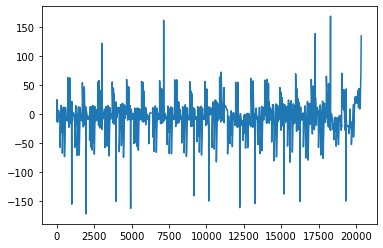

In [5]:
plt.plot(df_train['yaw_error'])

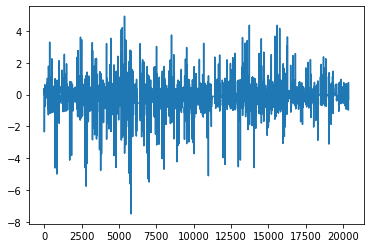

In [6]:
plt.plot(df_train['left_ail'])

# Fill paramater name to show correlation table

In [7]:
# Fill variable var_1 and var_2 with parameter name
var_1, var_2 = ("left_ail", 'right_ail')

pos_corr_1,neg_corr_1 = df_corr(df = df_train, var = var_1)
pos_corr_2,neg_corr_2 = df_corr(df = df_train, var = var_2)

## Show correlation table for first parameter

In [8]:
# Display positive and negative correlation dataframe
display(pos_corr_1.head(10))
display(neg_corr_1.head(10))

,pos_cor_left_ail
left_ail,100.00
rudder,10.65
lat,10.55
elevator,7.75
wind_dir,5.36
JSHead,4.93
ground_speed,3.54
TAS,3.54
alt,3.06
y_wp,2.40


,neg_corrleft_ail
right_ail,-96.02
JSRoll,-26.36
lon,-10.59
JSPitch,-8.63
Unnamed: 0.1.1,-7.08
phi,-6.53
psi,-5.55
num_wp,-3.37
thrust,-3.17
index,-2.73


## Show correlation table for second parameter

In [9]:
# Display positive and negative correlation dataframe
display(pos_corr_2.head(10))
display(neg_corr_2.head(10))

,pos_cor_right_ail
right_ail,100.00
JSRoll,24.96
phi,9.14
psi,8.83
yaw_reff,6.15
Unnamed: 0.1.1,4.07
theta,4.05
lat,3.09
wind_dir,2.76
elevator,2.08


,neg_corrright_ail
left_ail,-96.02
lon,-3.17
Unnamed: 0.1,-2.81
JSPitch,-2.28
y_wp,-1.27
Y,-1.26
Z,-1.07
alt,-0.30
num_wp,-0.29
wp_dist,-0.16


# Put features and targets in list

In [4]:
features_list = ['yaw_error']
targets_list = ['left_ail','right_ail']

## Generate features and targets array

In [5]:
X = df_to_array (df_train,features_list)
y = df_to_array (df_train,targets_list)

# Data Splitting (Training and Validation Set)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.03,shuffle=False)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_train = np.asarray(X_train).astype('float32')
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_val = np.asarray(X_val).astype('float32')

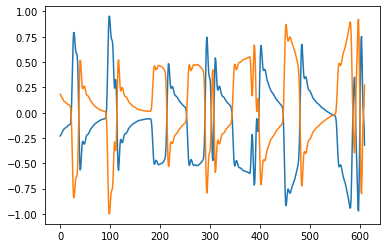

In [12]:
plt.plot(y_val)

In [13]:
# number of samples in X_val 
X_val.shape

(611, 1, 1)

In [14]:
X_train.shape

(19746, 1, 1)

## Define model function

# Keras Tuner

In [6]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,Bidirectional,LSTM,Bidirectional, Flatten
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import TensorBoard
from keras.constraints import maxnorm


hp = kt.HyperParameters()

def call_existing_code(units1, units_hidden, units_last, initializer, activation, optimizer, dropout, lr, num_hidden, x_train, y_train):
    model = Sequential()                            
    model.add(Bidirectional(LSTM(units=units1,
                                 input_shape=(x_train.shape[1], x_train.shape[2]),
                                 kernel_initializer=initializer,
                                 return_sequences=True)))
    
    # Add Hidden LSTM layers
    for i in range(num_hidden):
        model.add(Bidirectional(LSTM(units=units_hidden,
                                    return_sequences=True)))
    
    model.add(Bidirectional(LSTM(units=units_last)))
    
    # Add dropout layers
    if dropout:
        model.add(Dropout(rate=0.1))
        
    model.add(Dense(y_train.shape[1],
                    activation=activation))
    
    # Compiling Model
    model.compile(optimizer=optimizer,
                  loss="mean_squared_error",
                  metrics=["cosine_similarity"])
    
    return model

In [7]:
def build_model(hp):
    units1 = hp.Int("units1", min_value=8, max_value=32, step=4)
    units_hidden = hp.Int("units_hidden", min_value=8, max_value=32, step=4)
    units_last = hp.Int("units_last", min_value=8, max_value=32, step=4)
    num_hidden = hp.Choice('num_hidden', [0,1,2])
    initializer = hp.Choice('kernel_initializer',['uniform','normal', 'glorot_normal','glorot_uniform','he_normal'])
    activation = hp.Choice("activation", ['relu','elu','LeakyReLU'])
    optimizer = hp.Choice("optimizer", ['sgd', 'rmsprop', 'adam','adadelta', 'adagrad', 'adamax'])
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-3, max_value=1e-1, sampling="log")
    
    # Learning rate for optimizer 
    if optimizer == 'sgd':
        optimizer = SGD(learning_rate = lr)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate = lr)
    elif optimizer == 'adadelta':
        optimizer = Adadelta(learning_rate = lr)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate = lr)
    elif optimizer == 'adamax':
        optimizer = Adamax(learning_rate = lr)
    elif optimizer == 'adagrad':
        optimizer = Adagrad(learning_rate = lr)
    
    # call existing model-building code with the hyperparameter values.
    model = call_existing_code(units1=units1, units_hidden=units_hidden,
                               units_last=units_last, initializer=initializer,
                               activation=activation, dropout=dropout,
                               lr=lr, optimizer=optimizer,
                               num_hidden = num_hidden,
                               x_train=X_train, y_train=y_train)
    return model


build_model(kt.HyperParameters())

In [8]:
project_name = input('Project name:')

Project name:bayesopt7


In [9]:
tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective="loss",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="my_dir",
    project_name=project_name,
)

In [10]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early], verbose=1)

Trial 10 Complete [00h 03m 24s]
loss: 0.4831758439540863

Best loss So Far: 0.4831758439540863
Total elapsed time: 00h 18m 43s
INFO:tensorflow:Oracle triggered exit


In [64]:
tuner.results_summary()

Results summary
Results in my_dir\bayesopt7
Showing 10 best trials
Trial summary
Hyperparameters:
units1: 16
units_hidden: 12
units_last: 8
num_hidden: 2
kernel_initializer: uniform
activation: LeakyReLU
optimizer: adamax
dropout: True
lr: 0.0010324456695890764
Score: 0.4831758439540863
Trial summary
Hyperparameters:
units1: 20
units_hidden: 24
units_last: 8
num_hidden: 0
kernel_initializer: uniform
activation: LeakyReLU
optimizer: adamax
dropout: False
lr: 0.001
Score: 0.4861203134059906
Trial summary
Hyperparameters:
units1: 32
units_hidden: 20
units_last: 8
num_hidden: 1
kernel_initializer: he_normal
activation: LeakyReLU
optimizer: adamax
dropout: True
lr: 0.001
Score: 0.48934778571128845
Trial summary
Hyperparameters:
units1: 32
units_hidden: 32
units_last: 8
num_hidden: 2
kernel_initializer: glorot_normal
activation: LeakyReLU
optimizer: adamax
dropout: False
lr: 0.02376710871786189
Score: 0.49226880073547363
Trial summary
Hyperparameters:
units1: 24
units_hidden: 24
units_last: 

In [127]:
bs_list = [32,64,128,256]

loss_list=[]
for batch_size in bs_list:
    print('Currently training with number of batch size: ', batch_size)
    model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[stop_early], verbose=0)
    result = model.evaluate(X_train,y_train, verbose=0)
    cur_loss = result[0]
    loss_list.append(cur_loss)
    print(' -----> With batch size:{}, model losses is {:.3f}' .format(batch_size,cur_loss))

Currently training with number of batch size:  32
 -----> With batch size:32, model losses is 0.480
Currently training with number of batch size:  64
 -----> With batch size:64, model losses is 0.479
Currently training with number of batch size:  128
 -----> With batch size:128, model losses is 0.480
Currently training with number of batch size:  256
 -----> With batch size:256, model losses is 0.479


In [116]:
loss_list

[0.4793456494808197,
 0.4796045124530792,
 0.4808385968208313,
 0.4792576730251312]

In [128]:
loss_list

[0.4797987639904022,
 0.47940510511398315,
 0.47958704829216003,
 0.4792803227901459]

In [129]:
best_hps = tuner.get_best_hyperparameters(1)[0]

# Build the model with the best hp.
model = build_model(best_hps)
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), batch_size = 256, callbacks=[stop_early])

Epoch 1/200
78/78 [==============================] - 16s 41ms/step - loss: 0.6152 - cosine_similarity: 0.2176 - val_loss: 0.1469 - val_cosine_similarity: 0.1123
Epoch 2/200
78/78 [==============================] - 1s 8ms/step - loss: 0.5663 - cosine_similarity: 0.3314 - val_loss: 0.2200 - val_cosine_similarity: 0.0206
Epoch 3/200
78/78 [==============================] - 1s 8ms/step - loss: 0.5312 - cosine_similarity: 0.3168 - val_loss: 0.2389 - val_cosine_similarity: 0.0620
Epoch 4/200
78/78 [==============================] - 1s 8ms/step - loss: 0.5172 - cosine_similarity: 0.3547 - val_loss: 0.2704 - val_cosine_similarity: 0.0898
Epoch 5/200
78/78 [==============================] - 1s 8ms/step - loss: 0.5109 - cosine_similarity: 0.3776 - val_loss: 0.2828 - val_cosine_similarity: 0.1004
Epoch 6/200
78/78 [==============================] - 1s 8ms/step - loss: 0.5078 - cosine_similarity: 0.3861 - val_loss: 0.2929 - val_cosine_similarity: 0.1055
Epoch 7/200
78/78 [=========================

78/78 [==============================] - 1s 8ms/step - loss: 0.4928 - cosine_similarity: 0.3961 - val_loss: 0.3144 - val_cosine_similarity: 0.1190
Epoch 53/200
78/78 [==============================] - 1s 9ms/step - loss: 0.4934 - cosine_similarity: 0.3981 - val_loss: 0.3251 - val_cosine_similarity: 0.1139
Epoch 54/200
78/78 [==============================] - 1s 8ms/step - loss: 0.4916 - cosine_similarity: 0.3962 - val_loss: 0.2773 - val_cosine_similarity: 0.1191
Epoch 55/200
78/78 [==============================] - 1s 9ms/step - loss: 0.4917 - cosine_similarity: 0.3977 - val_loss: 0.2880 - val_cosine_similarity: 0.1188
Epoch 56/200
78/78 [==============================] - 1s 9ms/step - loss: 0.4912 - cosine_similarity: 0.3984 - val_loss: 0.2949 - val_cosine_similarity: 0.1174
Epoch 57/200
78/78 [==============================] - 1s 8ms/step - loss: 0.4901 - cosine_similarity: 0.3981 - val_loss: 0.3051 - val_cosine_similarity: 0.1151
Epoch 58/200
78/78 [==============================] -

In [51]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 1, 32)            2304      
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 1, 24)            4320      
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 1, 24)            3552      
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 16)               2112      
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 16)               

# Create Scanning Result Dataframe

In [55]:
a=[]
b=[]
c=[]
d=[]
e=[]
f=[]
g=[]
h=[]
j=[]

hps_list = tuner.get_best_hyperparameters(10)

for i in range(10):
    best_hps = hps_list[i]
    units1 = best_hps.get('units1')
    a.append(units1)
    
    units_hidden = best_hps.get('units_hidden')
    b.append(units_hidden)
    
    units_last = best_hps.get('units_last')
    c.append(units_last)
    
    num_hidden = best_hps.get('num_hidden')
    d.append(num_hidden)
    
    initializer = best_hps.get('kernel_initializer')
    e.append(initializer)
    
    activation = best_hps.get('activation')
    f.append(activation)
    
    optimizer = best_hps.get('optimizer')
    g.append(optimizer)
    
    dropout = best_hps.get('dropout')
    h.append(dropout)
    
    lr = best_hps.get('lr')
    j.append(lr)
    

In [56]:
df = pd.DataFrame(columns = ['units1','units_hidden', 'units_last',
                            'num_hidden', 'initializer','activation',
                            'optimizer', 'dropout', 'lr'])

df['units1'] = a
df['units_hidden'] = b
df['units_last'] = c
df['num_hidden'] = d
df['initializer'] = e
df['activation'] = f
df['optimizer'] = g
df['dropout'] = h
df['lr'] = j

df

,units1,units_hidden,units_last,num_hidden,initializer,activation,optimizer,dropout,lr
0,16,12,8,2,uniform,LeakyReLU,adamax,True,0.001032
1,20,24,8,0,uniform,LeakyReLU,adamax,False,0.001000
2,32,20,8,1,he_normal,LeakyReLU,adamax,True,0.001000
3,32,32,8,2,glorot_normal,LeakyReLU,adamax,False,0.023767
4,24,24,24,0,glorot_normal,elu,adagrad,True,0.003376
5,32,20,8,0,uniform,LeakyReLU,adamax,True,0.051850
6,28,12,20,1,normal,LeakyReLU,adam,False,0.006277
7,32,28,12,0,uniform,LeakyReLU,sgd,True,0.001000
8,12,32,32,0,he_normal,relu,adamax,True,0.001000
9,32,8,32,0,uniform,relu,adam,True,0.093841


# Plot accuracy and log-loss vs epochs

<AxesSubplot:title={'center':'Loss'}>

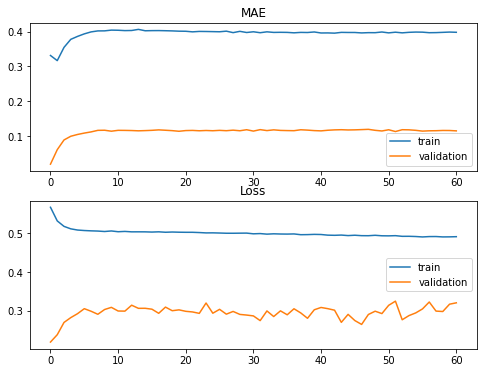

In [130]:
fig,axs = plt.subplots(2,figsize=(8,6))

loss_train = history.history['loss']
loss_val = history.history['val_loss']

metrics_train = history.history['cosine_similarity']
metrics_val = history.history['val_cosine_similarity']

pd.Series(metrics_train[1:]).rename('train').plot(legend=True,title='MAE',ax=axs[0])
pd.Series(metrics_val[1:]).rename('validation').plot(legend=True,ax=axs[0])

pd.Series(loss_train[1:]).rename('train').plot(legend=True,title='Loss',ax=axs[1])
pd.Series(loss_val[1:]).rename('validation').plot(legend=True,ax=axs[1])

## Load saved h5 model

In [8]:
import os

load_file_name = input('Write h5 file name to be load:')
extension = ".h5"
h5_file_name_load = load_file_name + extension

# Load Model from h5 file
model = keras.models.load_model(os.path.join('h5_models_file/',h5_file_name_load))

Write h5 file name to be load:bayesopt_batchtune1


# Plot prediction result from test set

File Name: data26.csv


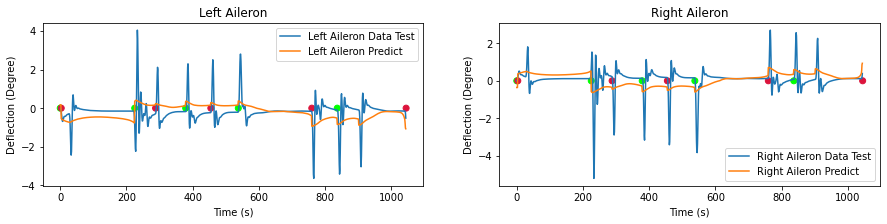

File Name: data41.csv


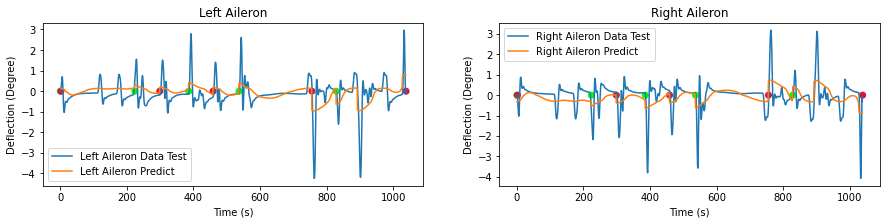

File Name: data42.csv


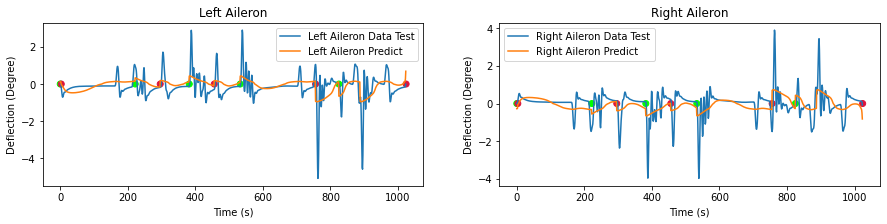

File Name: data43.csv


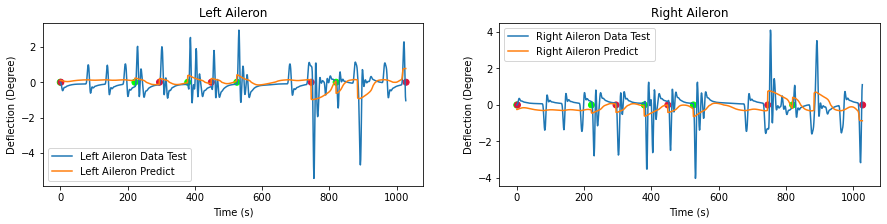

File Name: data44.csv


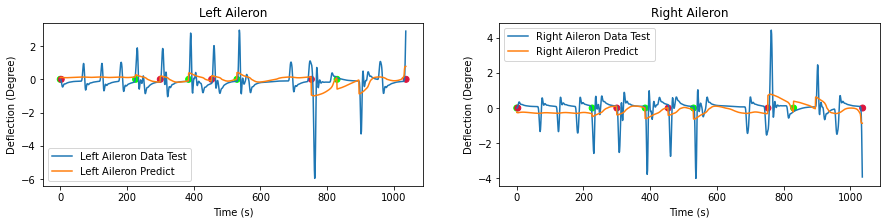

File Name: Data_test.csv


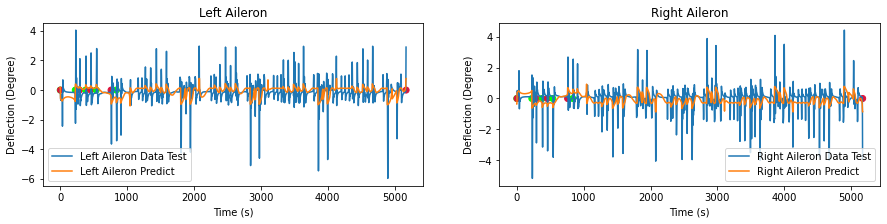

In [16]:
# Import Library
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from numpy import isnan, arange, rad2deg

# Collect all csv file format in choosen directory
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "D:\Documents\Akademik ITB\TA Waypoint Following\Data Test\*.csv"))

# Empty list to collect MSE value per file
MSE_left_elv = []
MSE_right_elv = []

# loop over the list of csv files
for f in csv_files:
    
    df_test = pd.read_csv(f)
    
    # Adjusting Yaw Error angle
    df_test = yaw_error_corrected(df_test)
    
    # Create  X_test and y_test variable using df_to_array function
    X_test = df_to_array(df_test,features_list)
    y_test = df_to_array(df_test,targets_list)


    X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    X_test = np.asarray(X_test).astype('float32')


    # Predict X_test using model that have been created
    ail_predicted = model.predict(X_test)
    
    # Create index x,y and color list
    indexes_x = index_wp(df_test)
    y = [0]*10
    color_list = ['lime', 'crimson']*5


    # Print each file name
    print('File Name:', f.split("\\")[-1])
    
    # Plot test graph and predicted graph in one graph
    figure, axis = plt.subplots(nrows=1, ncols=2,figsize=(15, 3))

    axis[0].plot(y_test[:,0], label='Left Aileron Data Test')
    axis[0].plot(ail_predicted[:,0], label='Left Aileron Predict')
    axis[0].scatter(indexes_x, y,color=color_list)
    axis[0].set_title("Left Aileron")
    axis[0].set_xlabel('Time (s)')
    axis[0].set_ylabel('Deflection (Degree)')
    axis[0].legend(loc='best')
    
    axis[1].plot(y_test[:,1], label='Right Aileron Data Test')
    axis[1].plot(ail_predicted[:,1], label='Right Aileron Predict')
    axis[1].scatter(indexes_x, y,color=color_list)
    axis[1].set_title("Right Aileron")
    axis[1].set_xlabel('Time (s)')
    axis[1].set_ylabel('Deflection (Degree)')
    axis[1].legend(loc='best')
    

    # Calling function to get mse value list without NaN 
    mse_without_nan(y_test[:,0],ail_predicted[:,0],MSE_left_elv)
    mse_without_nan(y_test[:,1],ail_predicted[:,1],MSE_right_elv)

    plt.show()


In [60]:
# Summary
from numpy import mean,std,max,min

print("Average MSE for left elevator test set is {:.1f} ".format(mean(MSE_left_elv)) +u"\u00B1 " +
      "{:.3f}".format(std(MSE_left_elv)) + " (for {} data)".format(len(MSE_left_elv)))
print("Average MSE for right elevator test set is {:.1f} ".format(mean(MSE_right_elv)) +u"\u00B1 "
      + "{:.3f}".format(std(MSE_right_elv)) + " (for {} data)".format(len(MSE_left_elv))+ "\n")

print('Lowest MSE for left elevator test set is {:.1f}'.format(min(MSE_left_elv)))
print('Lowest MSE for right elevator test set is {:.1f}'.format(min(MSE_right_elv)) + "\n")


print('Highest MSE for left elevator test set is {:.1f}'.format(max(MSE_left_elv)))
print('Highest MSE for right elevator test set is {:.1f}'.format(max(MSE_right_elv)) + "\n")

Average MSE for left elevator test set is 0.4 ± 0.028 (for 6 data)
Average MSE for right elevator test set is 0.4 ± 0.036 (for 6 data)

Lowest MSE for left elevator test set is 0.3
Lowest MSE for right elevator test set is 0.4

Highest MSE for left elevator test set is 0.4
Highest MSE for right elevator test set is 0.5



Text(0, 0.5, 'MSE (Degree)')

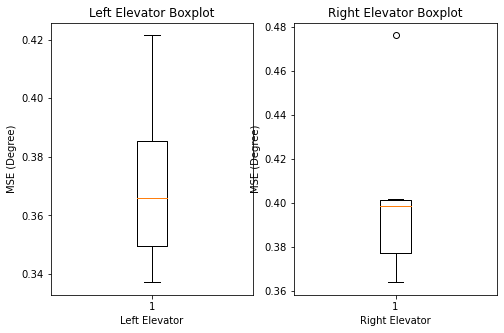

In [61]:
# Plotting Boxplot

figure, axis = plt.subplots(nrows=1, ncols=2,figsize=(8, 5))

axis[0].boxplot(MSE_left_elv)
axis[0].set_title("Left Elevator Boxplot")
axis[0].set_xlabel('Left Elevator')
axis[0].set_ylabel('MSE (Degree)')

axis[1].boxplot(MSE_right_elv)
axis[1].set_title("Right Elevator Boxplot")
axis[1].set_xlabel('Right Elevator')
axis[1].set_ylabel('MSE (Degree)')

## Saving model file as h5

In [126]:
file_name_save = input('Write h5 file name:')
extension = ".h5"
h5_file_name_save = file_name_save + extension

# Saving model as h5 file
model.save(os.path.join('h5_models_file/',h5_file_name_save))

Write h5 file name:bayesopt_batchtune1
